In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import tsgm
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import LSTM, Dense

import keras
import matplotlib.pyplot as plt


2024-02-21 14:35:39.745019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("NewTestDataCompiled.csv")
df.columns = ['Primary Saccade Amplitude (deg)', 'Secondary Saccade Amplitude (deg)', 'Saccade Latency', "Number of Corrective Saccades", "Normal"]
display(df)
df["Normal"].value_counts()



,Primary Saccade Amplitude (deg),Secondary Saccade Amplitude (deg),Saccade Latency,Number of Corrective Saccades,Normal
0,7.905335,0.907229,0.124998,7.0,0.0
1,17.381435,0.563108,0.341670,13.0,0.0
2,29.415535,1.097195,0.308346,16.0,0.0
3,10.173487,1.182019,0.175026,9.0,0.0
4,6.801426,7.733378,0.391700,28.0,0.0
...,...,...,...,...,...
251,0.806206,17.237696,0.291668,21.0,1.0
252,17.237696,16.043281,0.024999,16.0,1.0
253,8.092696,5.921643,0.025003,12.0,1.0
254,13.118551,2.170961,0.000005,10.0,1.0


Normal
0.0    137
1.0    119
Name: count, dtype: int64

In [58]:
from tabulate import tabulate

# Print DataFrame using tabulate
print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

# from prettytable import PrettyTable

# # Create a PrettyTable object
# pt = PrettyTable()
# pt.field_names = df.columns
# for row in df.itertuples(index=False):
#     pt.add_row(row)

# # Print the PrettyTable
# print(pt)

╒═════╤═══════════════════════════════════╤═════════════════════════════════════╤═══════════════════╤═════════════════════════════════╤══════════╕
│     │   Primary Saccade Amplitude (deg) │   Secondary Saccade Amplitude (deg) │   Saccade Latency │   Number of Corrective Saccades │   Normal │
╞═════╪═══════════════════════════════════╪═════════════════════════════════════╪═══════════════════╪═════════════════════════════════╪══════════╡
│   0 │                          7.90533  │                           0.907229  │          0.124998 │                               7 │        0 │
├─────┼───────────────────────────────────┼─────────────────────────────────────┼───────────────────┼─────────────────────────────────┼──────────┤
│   1 │                         17.3814   │                           0.563108  │          0.34167  │                              13 │        0 │
├─────┼───────────────────────────────────┼─────────────────────────────────────┼───────────────────┼─────────────────

# No Data Augmentation

In [3]:
y = df.Normal
X = df.drop('Normal', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### Logsitic Regression

In [4]:
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6346153846153846
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.86      0.72        28
         1.0       0.69      0.38      0.49        24

    accuracy                           0.63        52
   macro avg       0.65      0.62      0.60        52
weighted avg       0.65      0.63      0.61        52



Logistic Regression Feature Importance:
Feature 1: 0.003151289173087488
Feature 2: 0.03829437277210098
Feature 3: 0.8813647834388759
Feature 4: 0.025507550209668786


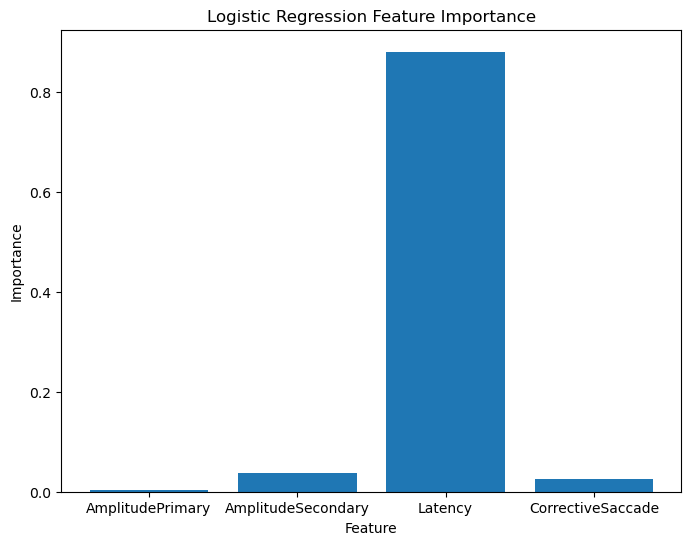

In [5]:
feature_importance_lr = np.abs(model.coef_[0])

print("Logistic Regression Feature Importance:")
for i, importance in enumerate(feature_importance_lr):
    print(f"Feature {i+1}: {importance}")

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importance_lr)), feature_importance_lr, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([0.03076923, 0.02692308, 0.05769231, 0.05384615]), 'importances_std': array([0.01961161, 0.0312463 , 0.02719641, 0.02826334]), 'importances': array([[ 0.01923077,  0.        ,  0.03846154,  0.03846154,  0.05769231],
       [-0.01923077,  0.03846154,  0.        ,  0.05769231,  0.05769231],
       [ 0.05769231,  0.09615385,  0.07692308,  0.01923077,  0.03846154],
       [ 0.07692308,  0.03846154,  0.03846154,  0.09615385,  0.01923077]])}


Text(0.5, 0, 'Permutation Importance')

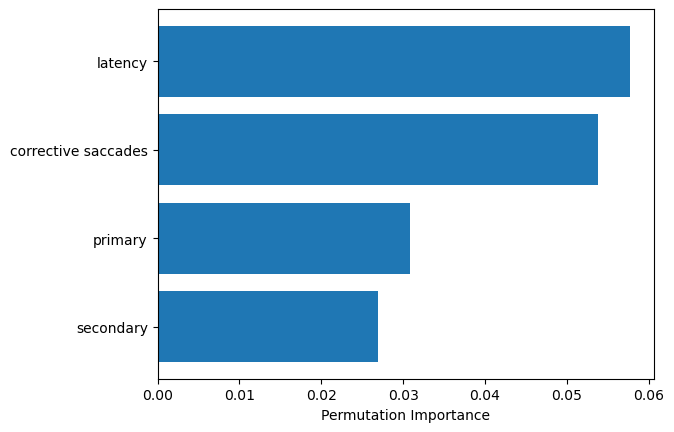

In [6]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Random Forest

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.5392682926829269


In [8]:
model = RandomForestClassifier(random_state=42, max_depth = None, n_estimators = 100, min_samples_leaf = 4, min_samples_split = 2)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6538461538461539
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.86      0.73        28
         1.0       0.71      0.42      0.53        24

    accuracy                           0.65        52
   macro avg       0.67      0.64      0.63        52
weighted avg       0.67      0.65      0.63        52



Random Forest Feature Importance:
Feature 1: 0.29816033929431385
Feature 2: 0.26314655458438685
Feature 3: 0.25502116262094815
Feature 4: 0.18367194350035118


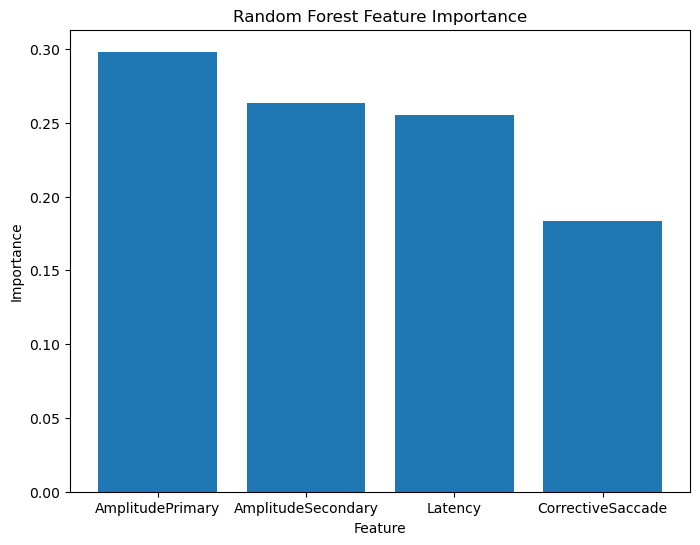

In [9]:
feature_importances_rf = model.feature_importances_

print("Random Forest Feature Importance:")
for i, importance in enumerate(feature_importances_rf):
    print(f"Feature {i+1}: {importance}")
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([0.08076923, 0.00384615, 0.09230769, 0.02692308]), 'importances_std': array([0.04452245, 0.06007884, 0.03922323, 0.01961161]), 'importances': array([[ 0.07692308,  0.01923077,  0.05769231,  0.15384615,  0.09615385],
       [-0.07692308,  0.        ,  0.09615385, -0.03846154,  0.03846154],
       [ 0.05769231,  0.09615385,  0.03846154,  0.13461538,  0.13461538],
       [ 0.05769231,  0.01923077,  0.        ,  0.03846154,  0.01923077]])}


Text(0.5, 0, 'Permutation Importance')

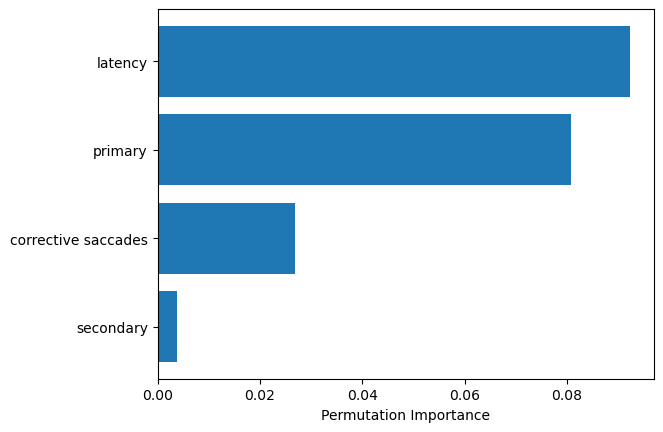

In [10]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### SVM 

In [11]:
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001]   # Kernel coefficient for 'rbf' and 'poly' kernels
#     'kernel': ['rbf', 'poly', 'linear']  # Kernel type
}

# Initialize the SVM model
svm = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'C': 1, 'gamma': 0.001}
Best Score: 0.5878048780487805


In [12]:
model = SVC(kernel='rbf', random_state=42, C = 1, gamma = .001)  # You can choose different kernels such as 'linear', 'poly', 'rbf', etc.

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5576923076923077
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.93      0.69        28
         1.0       0.60      0.12      0.21        24

    accuracy                           0.56        52
   macro avg       0.58      0.53      0.45        52
weighted avg       0.57      0.56      0.47        52



{'importances_mean': array([0.        , 0.04615385, 0.        , 0.02307692]), 'importances_std': array([0.        , 0.05908574, 0.        , 0.00769231]), 'importances': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09615385,  0.09615385,  0.01923077,  0.07692308, -0.05769231],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.03846154,  0.01923077,  0.01923077,  0.01923077,  0.01923077]])}


Text(0.5, 0, 'Permutation Importance')

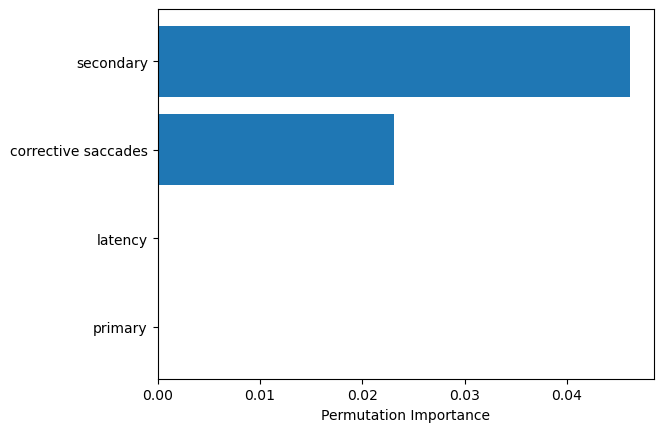

In [13]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### simple neural network

In [14]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/50
41/41 [==============================] - 1s 11ms/step - loss: 0.7292 - accuracy: 0.5337 - val_loss: 0.8961 - val_accuracy: 0.3902
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5460 - val_loss: 0.8727 - val_accuracy: 0.3659
Epoch 3/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.5890 - val_loss: 0.7697 - val_accuracy: 0.5854
Epoch 4/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.6442 - val_loss: 0.7916 - val_accuracy: 0.4634
Epoch 5/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.5951 - val_loss: 0.7724 - val_accuracy: 0.5122
Epoch 6/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.6626 - val_loss: 0.7221 - val_accuracy: 0.4634
Epoch 7/50
41/41 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6135 - val_loss: 0.7330 - val_accuracy: 0.5610
Epoch 8/50
41/41 [=

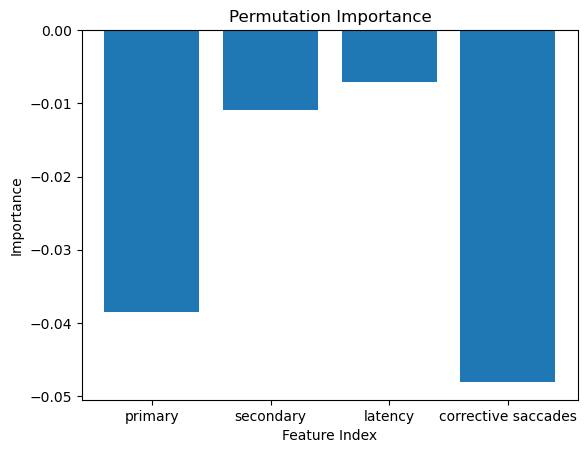

In [15]:

def custom_score(model, X, y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

perm_importance = permutation_importance(model, X_test, y_test, scoring=custom_score, n_repeats=30, random_state=42)


# Plot feature importance
plt.bar(['primary', 'secondary', 'latency', 'corrective saccades' ], perm_importance.importances_mean)
plt.xticks(range(len(perm_importance.importances_mean)))
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.show()


# Data Augmentation: Gaussain Noise 

In [16]:
def add_gaussian_noise(X, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=X.shape)
    return X + noise
# Example: Adding Gaussian noise with mean=0 and std=0.1
X_with_gaussian_noise = add_gaussian_noise(X)
X_augmented = pd.concat([X, X_with_gaussian_noise])
y_augmented = pd.concat([y,y])
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify = y_augmented)




### Logisitic Reg

In [17]:
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5922330097087378
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64        55
         1.0       0.57      0.48      0.52        48

    accuracy                           0.59       103
   macro avg       0.59      0.59      0.58       103
weighted avg       0.59      0.59      0.59       103



Logistic Regression Feature Importance:
Feature 1: 0.00713176355186074
Feature 2: 0.03333703683464893
Feature 3: 0.9818472734188397
Feature 4: 0.0328595866207674


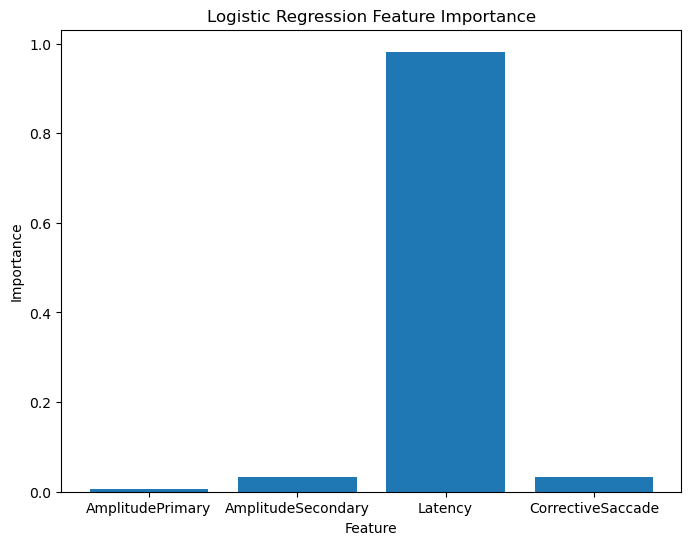

In [18]:
feature_importance_lr = np.abs(model.coef_[0])

print("Logistic Regression Feature Importance:")
for i, importance in enumerate(feature_importance_lr):
    print(f"Feature {i+1}: {importance}")

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importance_lr)), feature_importance_lr, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([0.00970874, 0.07184466, 0.08737864, 0.03300971]), 'importances_std': array([0.01228069, 0.04100721, 0.03735026, 0.02786932]), 'importances': array([[0.        , 0.        , 0.01941748, 0.02912621, 0.        ],
       [0.03883495, 0.12621359, 0.02912621, 0.11650485, 0.04854369],
       [0.04854369, 0.05825243, 0.08737864, 0.08737864, 0.15533981],
       [0.00970874, 0.        , 0.04854369, 0.02912621, 0.0776699 ]])}


Text(0.5, 0, 'Permutation Importance')

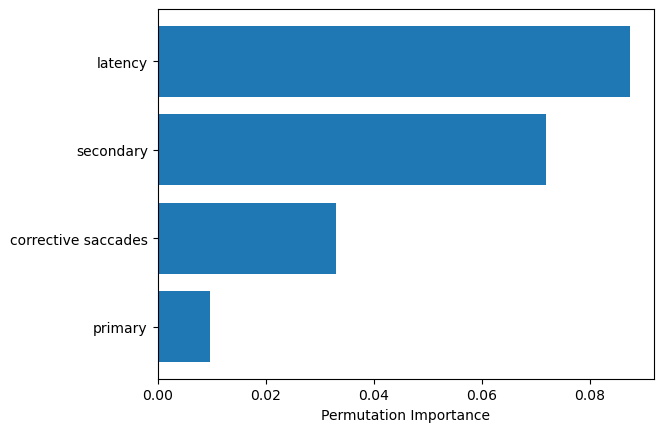

In [19]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### RF

In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.7922914784703403


In [21]:
model = RandomForestClassifier(random_state=42, max_depth = None, n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7475728155339806
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77        55
         1.0       0.75      0.69      0.72        48

    accuracy                           0.75       103
   macro avg       0.75      0.74      0.74       103
weighted avg       0.75      0.75      0.75       103



Random Forest Feature Importance:
Feature 1: 0.29288644052473756
Feature 2: 0.25313045747511664
Feature 3: 0.21303466772747523
Feature 4: 0.24094843427267065


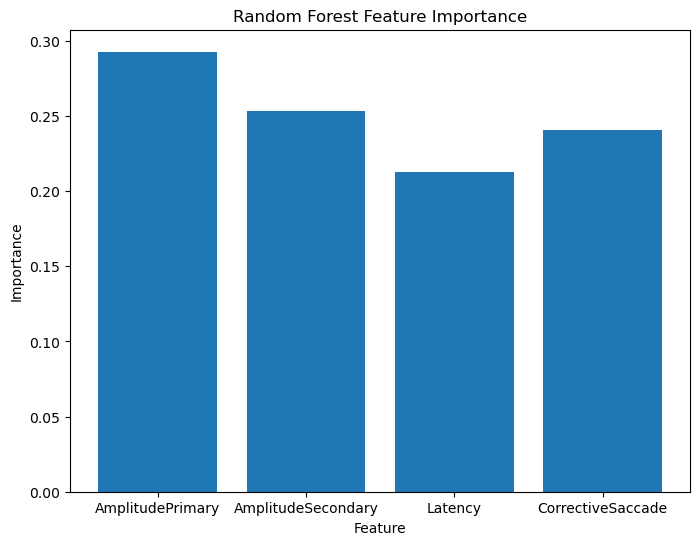

In [22]:
feature_importances_rf = model.feature_importances_

print("Random Forest Feature Importance:")
for i, importance in enumerate(feature_importances_rf):
    print(f"Feature {i+1}: {importance}")
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([0.17864078, 0.12815534, 0.05825243, 0.12621359]), 'importances_std': array([0.02501767, 0.02906142, 0.03306677, 0.03632677]), 'importances': array([[0.15533981, 0.17475728, 0.15533981, 0.18446602, 0.22330097],
       [0.11650485, 0.15533981, 0.13592233, 0.0776699 , 0.15533981],
       [0.03883495, 0.05825243, 0.10679612, 0.00970874, 0.0776699 ],
       [0.06796117, 0.14563107, 0.10679612, 0.13592233, 0.17475728]])}


Text(0.5, 0, 'Permutation Importance')

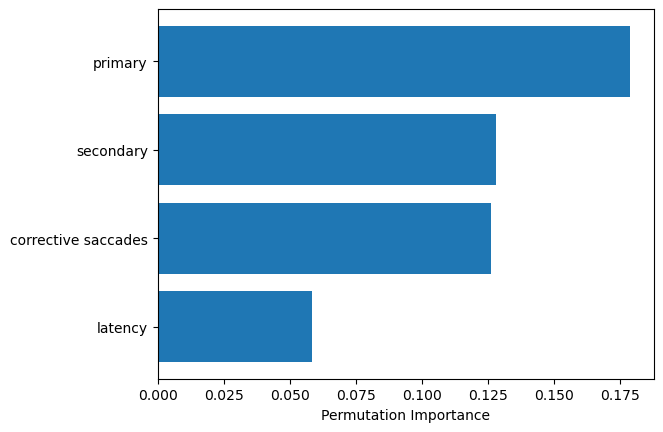

In [23]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### SVM 

In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001]   # Kernel coefficient for 'rbf' and 'poly' kernels
#     'kernel': ['rbf', 'poly', 'linear']  # Kernel type
}

# Initialize the SVM model
svm = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 10, 'gamma': 1}
Best Score: 0.8583559168925022


In [25]:
model = SVC(kernel='rbf', random_state=42, C = 10, gamma = 1)  # You can choose different kernels such as 'linear', 'poly', 'rbf', etc.

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.941747572815534
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95        55
         1.0       0.96      0.92      0.94        48

    accuracy                           0.94       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.94      0.94      0.94       103



{'importances_mean': array([0.38834951, 0.25825243, 0.        , 0.4038835 ]), 'importances_std': array([0.03580406, 0.049733  , 0.        , 0.02786932]), 'importances': array([[0.41747573, 0.3592233 , 0.33980583, 0.4368932 , 0.38834951],
       [0.22330097, 0.21359223, 0.34951456, 0.27184466, 0.23300971],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.37864078, 0.37864078, 0.44660194, 0.38834951, 0.42718447]])}


Text(0.5, 0, 'Permutation Importance')

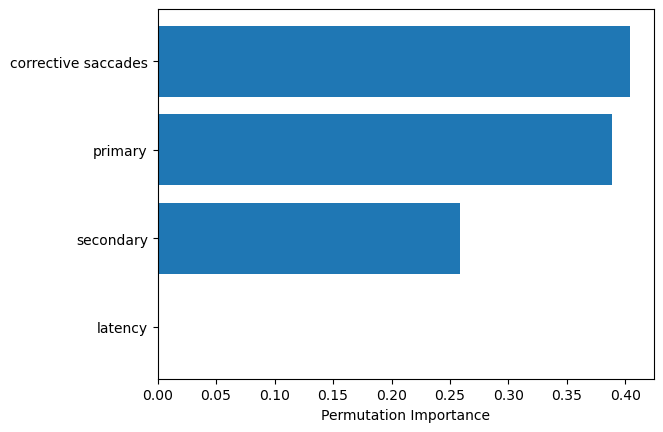

In [26]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### simple neural network

In [27]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/50
82/82 [==============================] - 1s 3ms/step - loss: 0.7177 - accuracy: 0.5260 - val_loss: 0.6705 - val_accuracy: 0.5854
Epoch 2/50
82/82 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5780 - val_loss: 0.6976 - val_accuracy: 0.6220
Epoch 3/50
82/82 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5902 - val_loss: 0.6522 - val_accuracy: 0.6341
Epoch 4/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.6208 - val_loss: 0.6608 - val_accuracy: 0.6341
Epoch 5/50
82/82 [==============================] - 0s 2ms/step - loss: 0.6715 - accuracy: 0.6116 - val_loss: 0.6511 - val_accuracy: 0.6341
Epoch 6/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.6024 - val_loss: 0.6233 - val_accuracy: 0.6707
Epoch 7/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6589 - accuracy: 0.5994 - val_loss: 0.6505 - val_accuracy: 0.5976
Epoch 8/50
82/82 [==

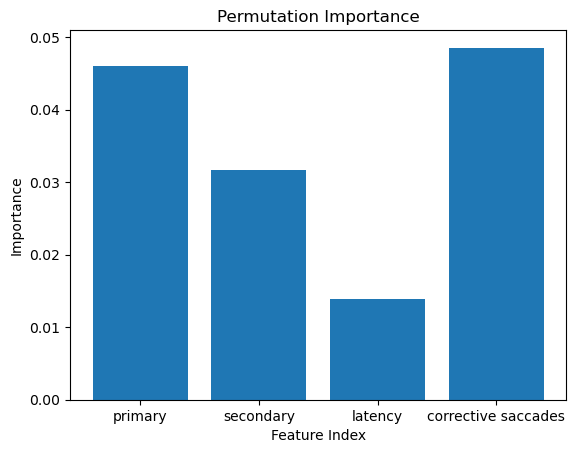

In [28]:

def custom_score(model, X, y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

perm_importance = permutation_importance(model, X_test, y_test, scoring=custom_score, n_repeats=30, random_state=42)


# Plot feature importance
plt.bar(['primary', 'secondary', 'latency', 'corrective saccades' ], perm_importance.importances_mean)
plt.xticks(range(len(perm_importance.importances_mean)))
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.show()


# Data Augmentation: Jittering

In [29]:
def add_jittering(X, magnitude=0.1):
    jitter = np.random.uniform(-magnitude, magnitude, size=X.shape)
    return X + jitter

# Example: Adding jittering with magnitude=0.1
X_with_jittering = add_jittering(X)

X_augmented = pd.concat([X, X_with_jittering])
y_augmented = pd.concat([y,y])
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify = y_augmented)



### Logisitic Reg

In [30]:
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5436893203883495
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60        55
         1.0       0.51      0.44      0.47        48

    accuracy                           0.54       103
   macro avg       0.54      0.54      0.54       103
weighted avg       0.54      0.54      0.54       103



Logistic Regression Feature Importance:
Feature 1: 6.629852282532471e-05
Feature 2: 0.02386980287170114
Feature 3: 1.140917649864345
Feature 4: 0.030238747045375575


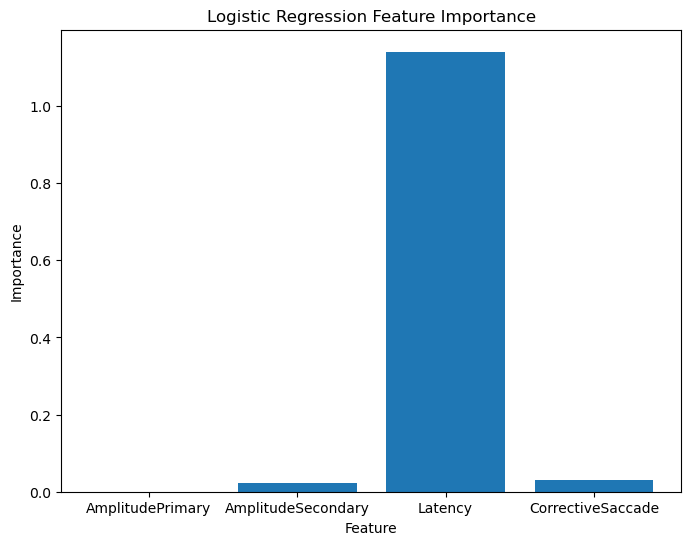

In [30]:
feature_importance_lr = np.abs(model.coef_[0])

print("Logistic Regression Feature Importance:")
for i, importance in enumerate(feature_importance_lr):
    print(f"Feature {i+1}: {importance}")

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importance_lr)), feature_importance_lr, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([ 0.        , -0.00204082,  0.06326531,  0.03061224]), 'importances_std': array([0.        , 0.0118999 , 0.02842528, 0.02738042]), 'importances': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01020408,  0.01020408,  0.        , -0.01020408, -0.02040816],
       [ 0.06122449,  0.08163265,  0.09183673,  0.07142857,  0.01020408],
       [ 0.03061224,  0.        ,  0.06122449,  0.06122449,  0.        ]])}


Text(0.5, 0, 'Permutation Importance')

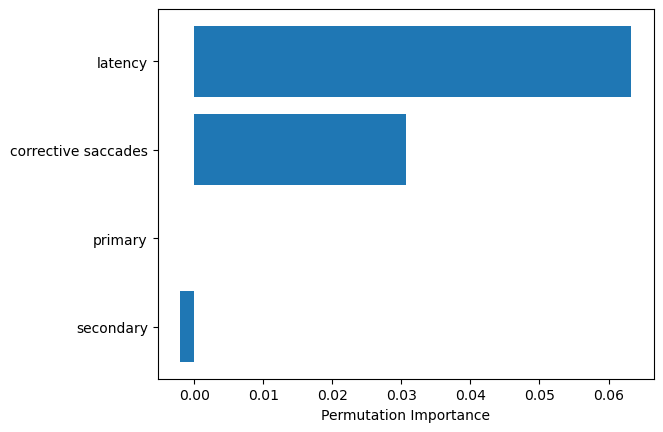

In [31]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### RF

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.8044866004215597


In [32]:
model = RandomForestClassifier(random_state=42, max_depth = None, n_estimators = 300, min_samples_leaf = 1, min_samples_split = 2)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7281553398058253
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75        55
         1.0       0.72      0.69      0.70        48

    accuracy                           0.73       103
   macro avg       0.73      0.73      0.73       103
weighted avg       0.73      0.73      0.73       103



Random Forest Feature Importance:
Feature 1: 0.28789150866965596
Feature 2: 0.23732596548454685
Feature 3: 0.2228811019995555
Feature 4: 0.2519014238462416


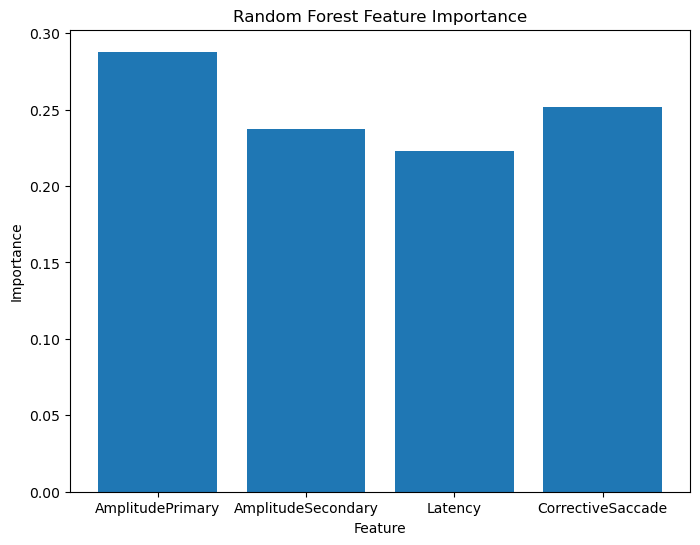

In [33]:
feature_importances_rf = model.feature_importances_

print("Random Forest Feature Importance:")
for i, importance in enumerate(feature_importances_rf):
    print(f"Feature {i+1}: {importance}")
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf, tick_label=['AmplitudePrimary', 'AmplitudeSecondary', 'Latency', "CorrectiveSaccade"])
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

{'importances_mean': array([0.17669903, 0.0815534 , 0.09514563, 0.13009709]), 'importances_std': array([0.02704541, 0.01316957, 0.02561341, 0.02425242]), 'importances': array([[0.19417476, 0.14563107, 0.21359223, 0.14563107, 0.18446602],
       [0.0776699 , 0.0776699 , 0.0776699 , 0.10679612, 0.06796117],
       [0.09708738, 0.10679612, 0.12621359, 0.09708738, 0.04854369],
       [0.10679612, 0.13592233, 0.15533981, 0.09708738, 0.15533981]])}


Text(0.5, 0, 'Permutation Importance')

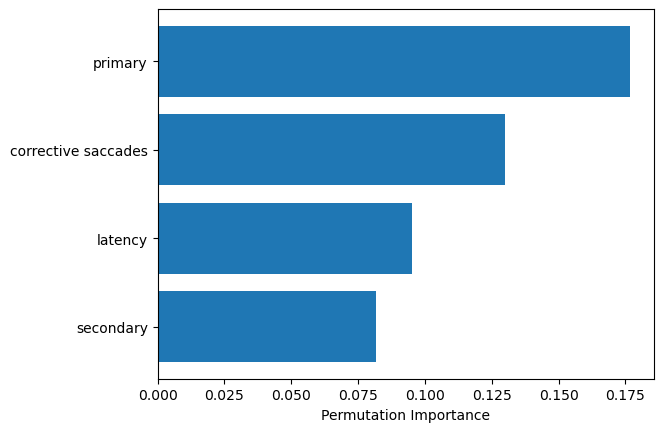

In [34]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### SVM

In [35]:
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001]   # Kernel coefficient for 'rbf' and 'poly' kernels
#     'kernel': ['rbf', 'poly', 'linear']  # Kernel type
}

# Initialize the SVM model
svm = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 10, 'gamma': 1}
Best Score: 0.8559168925022582


In [36]:
model = SVC(kernel='rbf', random_state=42, C = 10, gamma = 1)  # You can choose different kernels such as 'linear', 'poly', 'rbf', etc.

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.941747572815534
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95        55
         1.0       0.96      0.92      0.94        48

    accuracy                           0.94       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.94      0.94      0.94       103



{'importances_mean': array([0.36893204, 0.25436893, 0.00194175, 0.42135922]), 'importances_std': array([0.03008142, 0.01426887, 0.0038835 , 0.02919087]), 'importances': array([[0.34951456, 0.36893204, 0.34951456, 0.42718447, 0.34951456],
       [0.26213592, 0.24271845, 0.27184466, 0.26213592, 0.23300971],
       [0.        , 0.        , 0.00970874, 0.        , 0.        ],
       [0.39805825, 0.45631068, 0.42718447, 0.37864078, 0.44660194]])}


Text(0.5, 0, 'Permutation Importance')

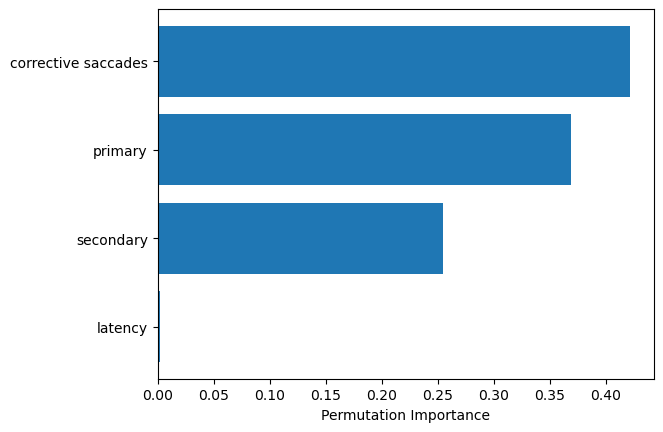

In [37]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(model, X_test, y_test)
print(perm_importance)

feature_names = ['primary', 'secondary', 'latency', 'corrective saccades' ]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### simple neural network 

In [38]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/50
82/82 [==============================] - 1s 3ms/step - loss: 0.7776 - accuracy: 0.5046 - val_loss: 0.6434 - val_accuracy: 0.5854
Epoch 2/50
82/82 [==============================] - 0s 1ms/step - loss: 0.7048 - accuracy: 0.5291 - val_loss: 0.6260 - val_accuracy: 0.6341
Epoch 3/50
82/82 [==============================] - 0s 2ms/step - loss: 0.7016 - accuracy: 0.5627 - val_loss: 0.6363 - val_accuracy: 0.6585
Epoch 4/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5443 - val_loss: 0.6302 - val_accuracy: 0.6829
Epoch 5/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6811 - accuracy: 0.6177 - val_loss: 0.6380 - val_accuracy: 0.6585
Epoch 6/50
82/82 [==============================] - 0s 1ms/step - loss: 0.6788 - accuracy: 0.5902 - val_loss: 0.6618 - val_accuracy: 0.5610
Epoch 7/50
82/82 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.6177 - val_loss: 0.6130 - val_accuracy: 0.6220
Epoch 8/50
82/82 [==

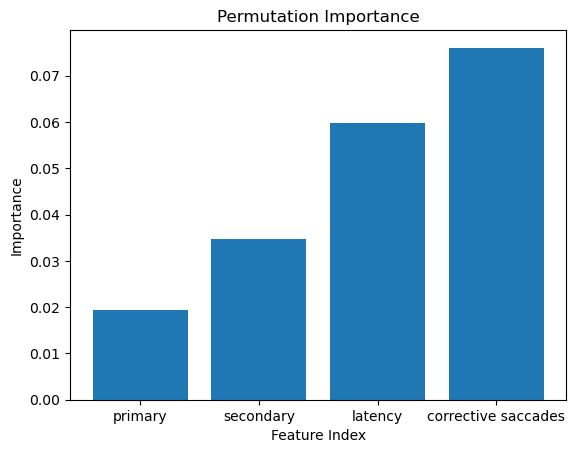

In [39]:

def custom_score(model, X, y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

perm_importance = permutation_importance(model, X_test, y_test, scoring=custom_score, n_repeats=30, random_state=42)


# Plot feature importance
plt.bar(['primary', 'secondary', 'latency', 'corrective saccades' ], perm_importance.importances_mean)
plt.xticks(range(len(perm_importance.importances_mean)))
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.show()


# Data Augmentation: GAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Generator network
def build_generator(latent_dim, num_features):
    model = keras.Sequential([
    layers.Dense(512, activation='relu', input_dim=latent_dim),  # Increase the number of neurons and depth
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),  # Increase the number of neurons and depth
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),  # Increase the number of neurons and depth
    layers.BatchNormalization(),
    layers.Dense(num_features, activation='sigmoid')
    ])
    return model

def build_discriminator(num_features):
    model = keras.Sequential([
        layers.Dense(1024, activation='relu', input_dim=num_features),  # Increase the number of neurons and depth
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),  # Increase the number of neurons and depth
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),  # Increase the number of neurons and depth
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential([generator, discriminator])
    return model

# Training GAN
def train_gan(generator, discriminator, gan, X_train, y_train, latent_dim, num_epochs=100, batch_size=32, logging_interval=1000, convergence_threshold=0.1, convergence_patience=5):
    best_discriminator_loss = float('inf')
    best_generator_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)
        
        # Select a random batch of real samples
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train.iloc[idx]
        
        # Concatenate real and fake samples
        X = np.concatenate([real_samples, generated_data])
        
        # Labels for real and fake samples
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate([y_real, y_fake])
        
        # Train discriminator
        discriminator_loss = discriminator.train_on_batch(X, y)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = gan.train_on_batch(noise, y_real)
        
        # Logging
        if epoch % logging_interval == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")
        
        # Convergence monitoring
        if discriminator_loss < best_discriminator_loss - convergence_threshold and generator_loss < best_generator_loss - convergence_threshold:
            best_discriminator_loss = discriminator_loss
            best_generator_loss = generator_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= convergence_patience:
            print(f"Convergence reached at epoch {epoch}")
            break

# Train GAN with convergence monitoring

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Generate synthetic samples
def generate_samples(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_data = generator.predict(noise)
    return generated_data

# Load data
# Assuming your DataFrame is named df, and the target column is named 'abnormal'
# Drop the target column to get the feature data
# X = df.drop(columns=['normal']).values
# y = df['normal'].values.reshape(-1, 1)

# Split the data into training and testing sets

# Parameters
latent_dim = 100
num_features = X_train.shape[1]

# Build and compile models
generator = build_generator(latent_dim, num_features)
discriminator = build_discriminator(num_features)
gan = build_gan(generator, discriminator)
optimizer = Adam(learning_rate=0.0001)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
# discriminator.compile(optimizer='adam', loss='binary_crossentropy')
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Train GAN
train_gan(generator, discriminator, gan, X_train, y_train, latent_dim)

# Generate samples
generated_samples = generate_samples(generator, latent_dim, 1000)

# Plot generated samples
# plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], color='blue', alpha=0.5, label='Real Data')
# plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='red', alpha=0.5, label='Generated Data')
# plt.legend()
# plt.show()

display(generated_samples)


In [ ]:
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], color='blue', alpha=0.5, label='Real Data')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='red', alpha=0.5, label='Generated Data')
plt.legend()
plt.show()